# Example: Classification

In [1]:
import matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector
from torch.optim import Adam

from preds.models import MLPS
from preds.likelihoods import CategoricalLh
from preds.datasets import TwoMoons
from preds.laplace import Laplace
from preds.utils import setup_grid

#### Hyperparameters

In [2]:
width = 25
depth = 3
prior_prec = 1
lr = 5e-3
n_epochs = 250
n_samples = 5000
lh = CategoricalLh()

#### Two moons dataset

In [3]:
device = 'cpu'
ds = TwoMoons(random_seed=711, double=False)
X_train, y_train = ds.data.to(device), ds.targets.to(device).long()
train_loader = [(X_train, y_train)]  # mock

#### Grid for plotting predictive

In [4]:
grid, xx, yy = setup_grid(ds.data.numpy(), h=0.05, buffer=1)
grid = grid.to(device).float()
X = ds.data.numpy()
y = ds.targets.numpy()

clevels = 30  # color levels in contour
ms = 50  # marker size

def plot_contour(pred_Z, ax=plt):
    Z = pred_Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, alpha=0.7, cmap='RdBu', levels=clevels, antialiased=True, vmin=0, vmax=1)
    ax.scatter(X[y==0, 0], X[y==0, 1], color='tab:blue', s=ms, lw=1, edgecolors='black', marker='o')
    ax.scatter(X[y==1, 0], X[y==1, 1], color='tab:red', s=ms, lw=1, edgecolors='black', marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    return contour

## Neural network training (MAP estimation)

In [5]:
model = MLPS(2, [width]*depth, 2, activation='tanh').to(device)
optim = Adam(model.parameters(), lr=lr)
losses = list()
for i in range(n_epochs):
    f = model(X_train)
    w = parameters_to_vector(model.parameters())
    reg = 0.5 * prior_prec * w @ w
    loss = - lh.log_likelihood(y_train, f) + reg
    loss.backward()
    optim.step()
    losses.append(loss.item())
    model.zero_grad()

## Infer Laplace-_GGN_ and predict

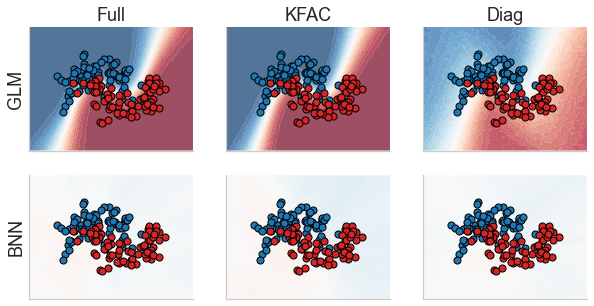

In [6]:
lap = Laplace(model, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        return lap.predictive_samples_glm(grid, n_samples=1000).mean(axis=0)[:, 0]
    elif model_type == 'bnn':
        return lap.predictive_samples_bnn(grid, n_samples=1000).mean(axis=0)[:, 0]
    else:
        raise ValueError('unsupported model_type.')


# Plot predictions of GLM and BNN in grid
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))

axs[0, 0].set_title('Full', fontsize=18)
axs[0, 1].set_title('KFAC', fontsize=18)
axs[0, 2].set_title('Diag', fontsize=18)
axs[0, 0].set_ylabel('GLM', fontsize=18)
axs[1, 0].set_ylabel('BNN', fontsize=18)

# GLM
pred = get_pred_for('glm', 'full')
plot_contour(pred, ax=axs[0, 0])
pred = get_pred_for('glm', 'kron')
plot_contour(pred, ax=axs[0, 1])
pred = get_pred_for('glm', 'diag')
plot_contour(pred, ax=axs[0, 2])

# NN
pred = get_pred_for('bnn', 'full')
plot_contour(pred, ax=axs[1, 0])
pred = get_pred_for('bnn', 'kron')
plot_contour(pred, ax=axs[1, 1])
pred = get_pred_for('bnn', 'diag')
plot_contour(pred, ax=axs[1, 2])

plt.show()